* jaccard係数をクラスタリングしてクラスタ0を使って教師ありで学習

In [ ]:
# jaccard係数をクラスタリングしてクラスタ0を使って教師ありで学習
import os
import logging
import resource
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IOHMM import SemiSupervisedIOHMM
from IOHMM import CrossEntropyMNL, DiscreteMNL

In [3]:
# メモリ・CPU 制限設定

def set_limits(max_mem_mb=None, max_cpu_sec=None):
    if max_mem_mb:
        mb = max_mem_mb * 1024 * 1024
        resource.setrlimit(resource.RLIMIT_AS, (mb, mb))
        logging.info(f"RLIMIT_AS={max_mem_mb}MB")
    if max_cpu_sec:
        resource.setrlimit(resource.RLIMIT_CPU, (max_cpu_sec, max_cpu_sec))
        logging.info(f"RLIMIT_CPU={max_cpu_sec}s")

In [4]:
# smoothing を加えた DiscreteMNL
class SmoothedDiscreteMNL(DiscreteMNL):
    def __init__(self, solver='lbfgs', alpha=1.0, **kw):
        super().__init__(solver=solver, **kw)
        self.alpha = alpha
    def predict_log_proba(self, X):
        logp = super().predict_log_proba(X)
        if self.alpha == 0:
            return logp 
        p    = np.exp(logp)
        p += self.alpha
        p /= p.sum(axis=1, keepdims=True)
        return np.log(p)
    def loglike_per_sample(self, X, y):
        y_idx = y.ravel().astype(int)
        lp    = self.predict_log_proba(X)
        return lp[np.arange(len(y_idx)), y_idx]

In [6]:
from sklearn.preprocessing import OneHotEncoder

def prepare_dfs_states(df_p, test_size=0.2, random_state=42):
    req = ['balls','strikes','pitch_type','zone_cluster',
           'pitch_cluster_label','zone','pitcher','game_pk']
    missing = [c for c in req if c not in df_p.columns]
    if missing:
        raise RuntimeError(f"Missing columns: {missing}")
    df = df_p.dropna(subset=['pitch_cluster_label','zone_cluster']).reset_index(drop=True)

    le_zcl = LabelEncoder().fit(df['zone_cluster'])
    le_z   = LabelEncoder().fit(df['zone'])
    le_pcl = LabelEncoder().fit(df['pitch_cluster_label'])

    df['zone_cluster']        = le_zcl.transform(df['zone_cluster'])
    df['zone']                = le_z.transform(df['zone'])
    df['pitch_cluster_label'] = le_pcl.transform(df['pitch_cluster_label'])

    df['state_id'] = df['zone']
    num_states = df['state_id'].nunique()

    # ✅ OneHotエンコード
    all_combinations = [[b, s] for b in range(4) for s in range(3)]
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(all_combinations)

    X_ohe = ohe.transform(df[['balls', 'strikes']])
    input_features = ohe.get_feature_names_out(['balls', 'strikes'])
    df_ohe = pd.DataFrame(X_ohe, columns=input_features)
    df = pd.concat([df.reset_index(drop=True), df_ohe], axis=1)

    seqs = {f"{p}_game_{g}": gdf.reset_index(drop=True)
            for (p, g), gdf in df.groupby(['pitcher','game_pk'])
            if len(gdf) >= 2}

    keys = list(seqs.keys())
    train_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=random_state)

    eye = np.eye(num_states)
    dfs_train, dfs_test = [], []
    for k in train_keys:
        s = seqs[k]
        state_map = {t: eye[z] for t, z in zip(s.index, s['zone'])}
        dfs_train.append([s, state_map])
    for k in test_keys:
        s = seqs[k]
        dfs_test.append([s, {}])
    test_df = pd.concat([seqs[k] for k in test_keys], axis=0, ignore_index=True)

    return dfs_train, dfs_test, num_states, test_df, le_zcl, le_z, le_pcl, ohe, input_features.tolist()


In [ ]:
def build_and_train(dfs_train, num_states, input_features, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    shmm = SemiSupervisedIOHMM(num_states=num_states)
    shmm.set_models(
        model_emissions=[SmoothedDiscreteMNL(solver='lbfgs'),
                         SmoothedDiscreteMNL(solver='lbfgs')],
        model_transition=CrossEntropyMNL(solver='lbfgs'),
        model_initial=   CrossEntropyMNL(solver='lbfgs')
    )
    shmm.set_inputs(
        covariates_initial=input_features,
        covariates_transition=input_features,
        covariates_emissions=[input_features, input_features]
    )
    shmm.set_outputs([['pitch_cluster_label'], ['zone_cluster']])
    shmm.set_data(dfs_train)
    shmm.train()
    with open(os.path.join(save_dir, 'model.pkl'), 'wb') as f:
        pickle.dump(shmm, f)
    logging.info(f"Saved model to {save_dir}/model.pkl | LogLikelihood={shmm.log_likelihood:.4f}")


In [ ]:
# メイン処理
if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
    set_limits(max_mem_mb=32000)
    # 全体データ読み込み
    df_all = pd.read_csv('statcast_pitcher_clster.csv')
    # 
    df_p = df_all[df_all['pitcher_cluster']==0].copy()
    # 各投手ごとにモデル学習 & テストデータ・エンコーダー保存
    # 前処理 & split
    dfs_train, dfs_test, ns, test_df, le_zcl, le_z, le_pcl, ohe, input_features = prepare_dfs_states(df_p)
    out_dir = f'iohmm_cluster_0_Laplace_nosm'
    os.makedirs(out_dir, exist_ok=True)
    test_df.to_csv(os.path.join(out_dir, 'test_data.csv'), index=False)
    logging.info(f"Saved test data to {out_dir}/test_data.csv")
    # ✅ ohe と input_features も保存
    with open(os.path.join(out_dir, 'encoders.pkl'), 'wb') as f:
        pickle.dump({
            'le_zone_cluster': le_zcl,
            'le_zone': le_z,
            'le_pitch_cluster_label': le_pcl,
            'ohe_input': ohe,
            'input_features': input_features
        }, f)
    logging.info(f"Saved encoders to {out_dir}/encoders.pkl")
    build_and_train(dfs_train, ns, input_features, save_dir=out_dir)


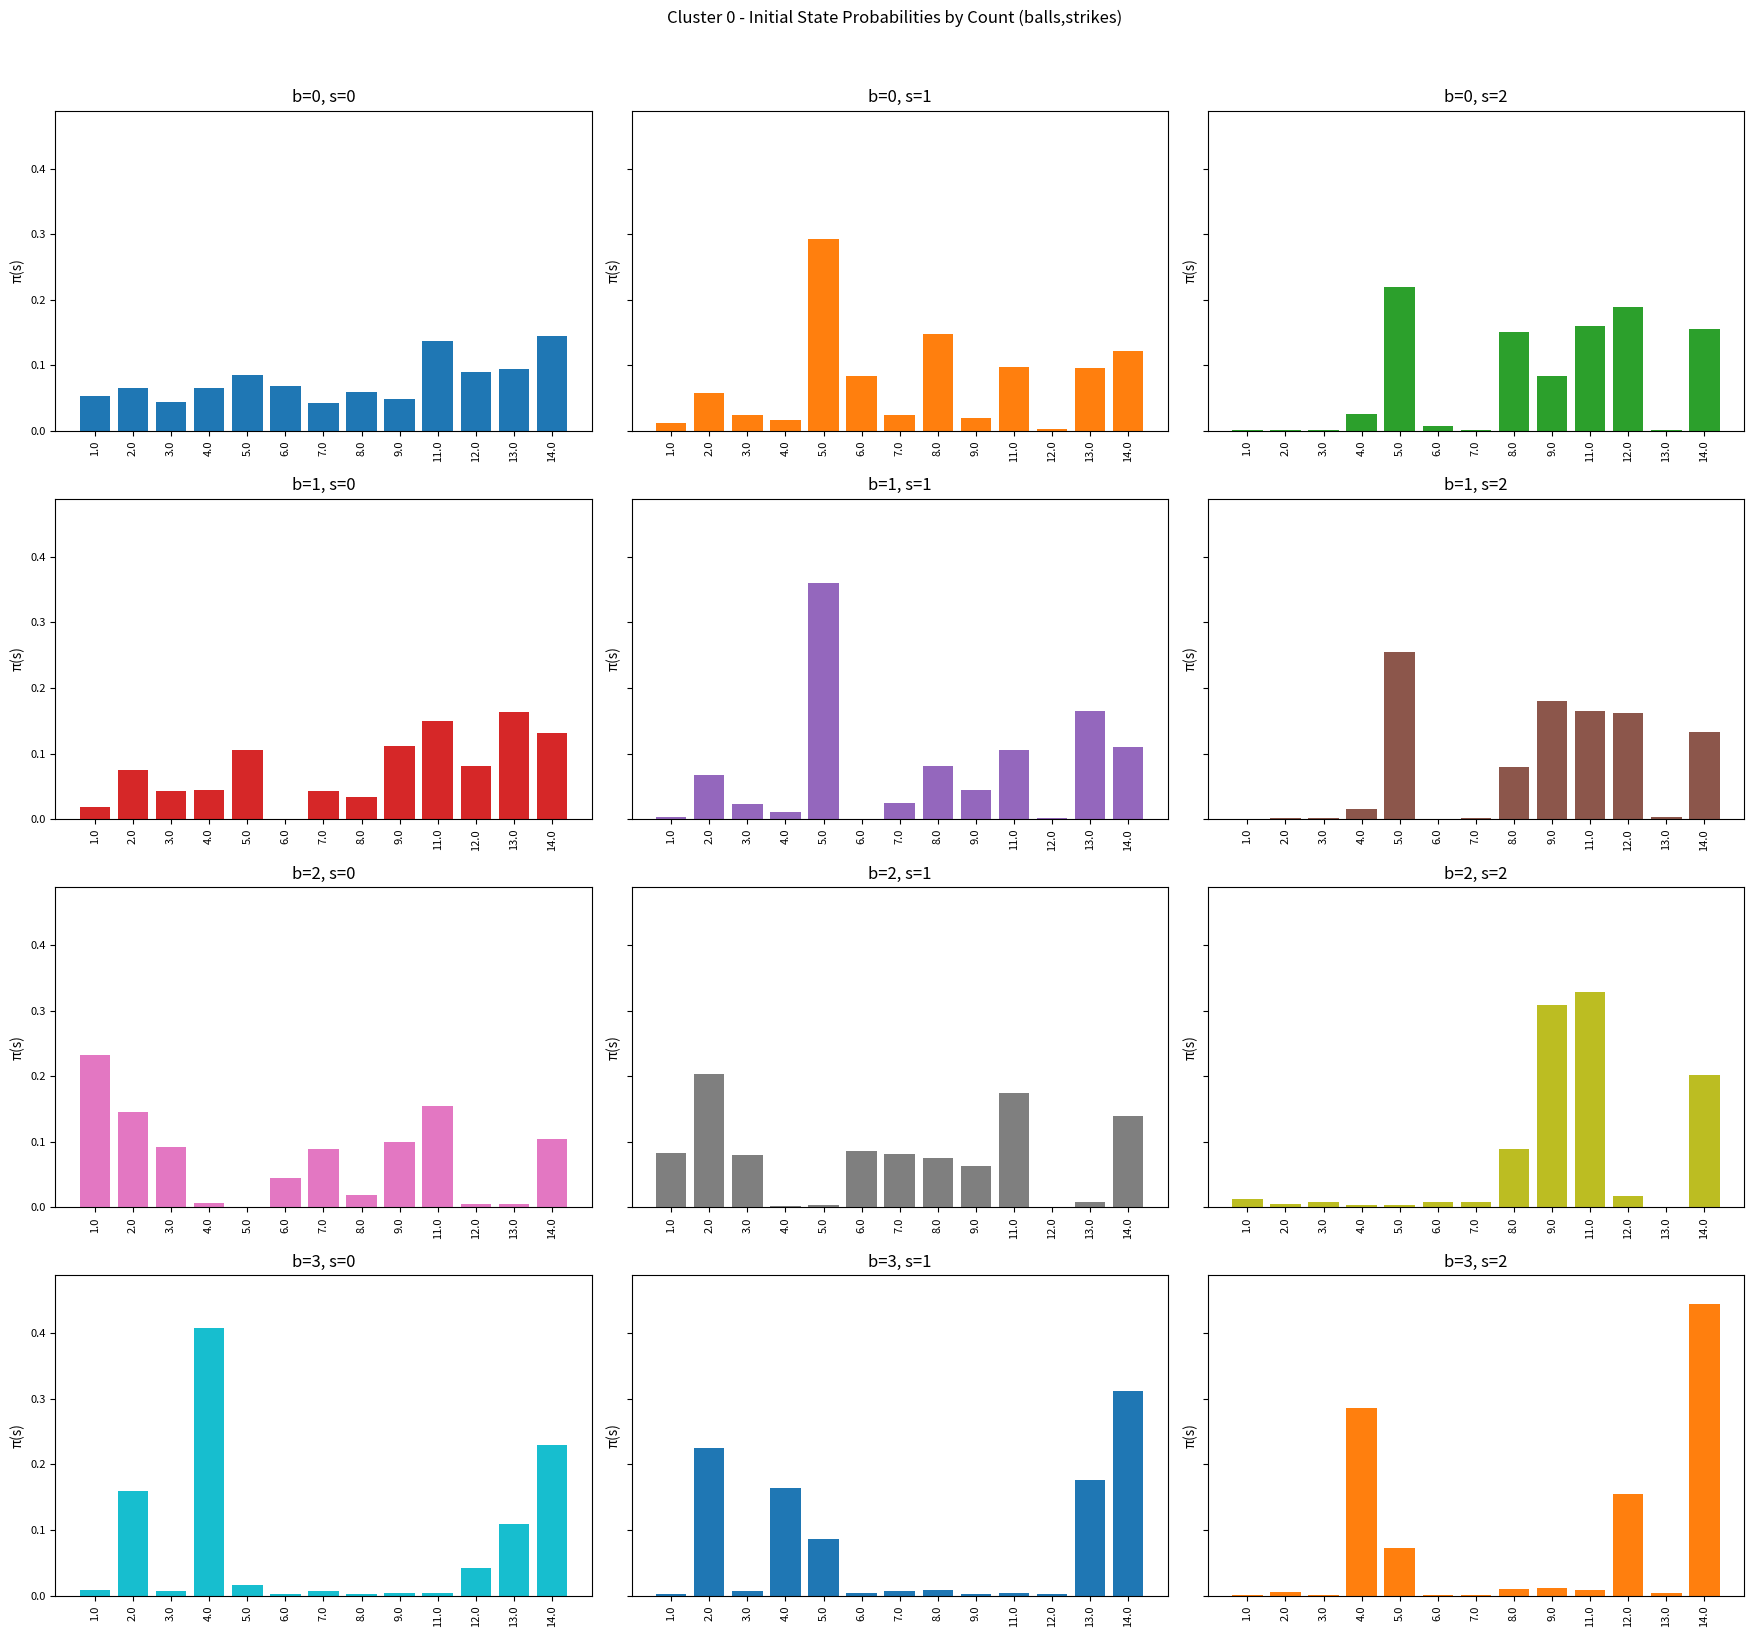

In [51]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# クラスタ番号のリスト（必要なクラスタを指定）
cluster_list = [0]  # 必要に応じて変更

# balls-strikes 全組み合わせ
covs = [(b, s) for b in range(4) for s in range(3)]
n_cov = len(covs)
n_cols = 3
n_rows = ceil(n_cov / n_cols)

for cluster in cluster_list:
    model_dir = f"iohmm_cluster_{cluster}_Laplace"
    model_fp  = os.path.join(model_dir, "model.pkl")
    enc_fp    = os.path.join(model_dir, "encoders.pkl")

    if not os.path.isfile(model_fp) or not os.path.isfile(enc_fp):
        print(f"[Cluster {cluster}] モデルまたはエンコーダが見つかりません。スキップします。")
        continue

    with open(model_fp, "rb") as mf:
        shmm_loaded = pickle.load(mf)
    with open(enc_fp, "rb") as ef:
        encs = pickle.load(ef)

    le_z = encs["le_zone"]
    ohe = encs["ohe_input"]

    state_ids = np.arange(shmm_loaded.num_states)
    state_labels = le_z.inverse_transform(state_ids)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"Cluster {cluster} - Initial State Probabilities by Count (balls,strikes)", y=1.02)

    for idx, (b, s) in enumerate(covs):
        ax = axes[idx]
        x_input = ohe.transform([[b, s]])
        pi = np.exp(shmm_loaded.model_initial.predict_log_proba(x_input)).flatten()

        x = np.arange(len(state_labels))
        ax.bar(x, pi, color=f"C{idx % 10}")
        ax.set_title(f"b={b}, s={s}", fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(state_labels, rotation=90, fontsize=8)
        ax.set_ylabel("π(s)", fontsize=10)
        ax.set_ylim(0, pi.max() * 1.1)
        ax.yaxis.set_tick_params(labelsize=8)

    for j in range(n_cov, n_rows * n_cols):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0, 0.98, 1.00])
    plt.show()


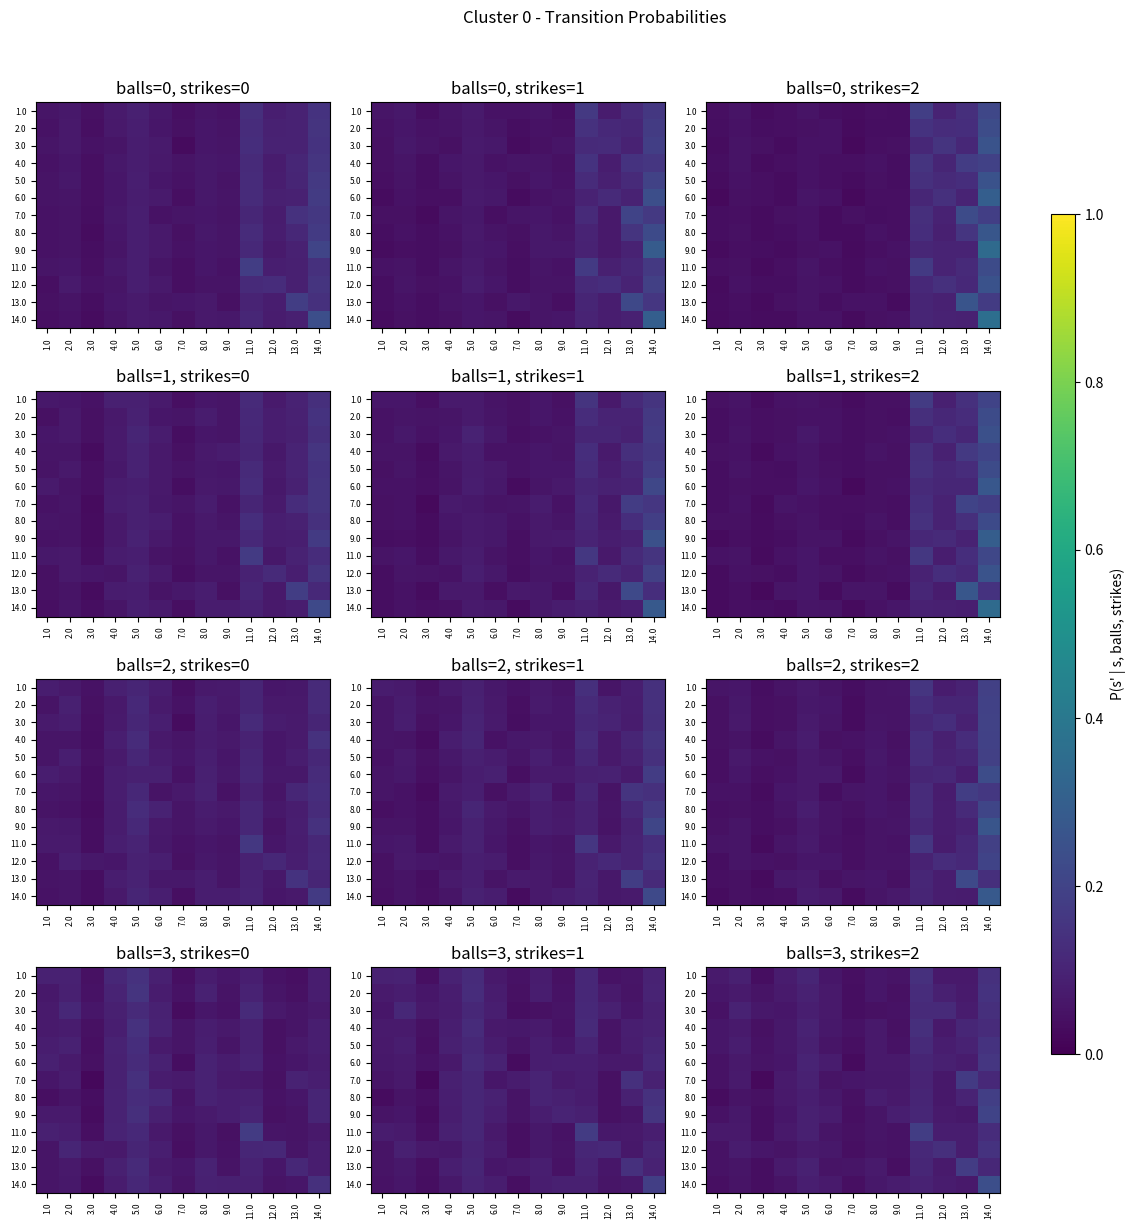

In [52]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# クラスタ番号のリスト（必要に応じて変更）
cluster_list = [0]  # すべてやりたいときは range(29) など

# balls-strikes の全組み合わせ
covs = [(b, s) for b in range(4) for s in range(3)]  # 4×3 = 12パターン

for cluster in cluster_list:
    model_dir = f"iohmm_cluster_{cluster}_Laplace"
    model_fp = os.path.join(model_dir, "model.pkl")
    enc_fp   = os.path.join(model_dir, "encoders.pkl")

    if not os.path.isfile(model_fp):
        print(f"[Cluster {cluster}] モデルファイルが見つかりません ({model_fp})")
        continue
    if not os.path.exists(enc_fp):
        print(f"[Cluster {cluster}] エンコーダーファイルが見つかりません: {enc_fp}")
        continue

    with open(model_fp, "rb") as mf:
        shmm_loaded = pickle.load(mf)
    with open(enc_fp, "rb") as ef:
        encs = pickle.load(ef)

    le_z = encs["le_zone"]
    ohe  = encs["ohe_input"]

    n_states     = shmm_loaded.num_states
    state_ids    = np.arange(n_states)
    state_labels = le_z.inverse_transform(state_ids)

    # グリッド図
    fig, axes = plt.subplots(4, 3, figsize=(12, 12))
    fig.suptitle(f"Cluster {cluster} - Transition Probabilities", y=1.02)

    for idx, (b, s) in enumerate(covs):
        ax = axes.flat[idx]

        x_input = ohe.transform([[b, s]])  # OneHotで状態条件をエンコード

        # 各状態 s から次状態への遷移確率ベクトル
        trans_mat = np.vstack([
            np.exp(shmm_loaded.model_transition[st].predict_log_proba(x_input))
            for st in range(n_states)
        ])

        im = ax.imshow(trans_mat, vmin=0, vmax=1, aspect='auto', cmap=cm.viridis)
        ax.set_title(f"balls={b}, strikes={s}")
        ax.set_xticks(range(n_states))
        ax.set_yticks(range(n_states))
        ax.set_xticklabels(state_labels, rotation=90, fontsize=6)
        ax.set_yticklabels(state_labels,           fontsize=6)

    # 共通カラーバー
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(s' | s, balls, strikes)")
    plt.tight_layout(rect=[0, 0, 0.85, 1.0])
    plt.show()


In [53]:
import matplotlib.font_manager as fm

for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if 'ipag' in font.lower() or 'noto' in font.lower():
        print(font)


/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Thin.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Light.ttc
/usr/share/fonts/truetype/noto/NotoColorEmoji.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc
/usr/share/fonts/truetype/noto/NotoSansMono-Bold.ttf
/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Black.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc
/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf
/usr/share/fonts/truetype/noto/NotoSansMono-Regular.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-SemiBold.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-ExtraLight.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-Medium.ttc
/usr/share/fonts/opentype/noto/N

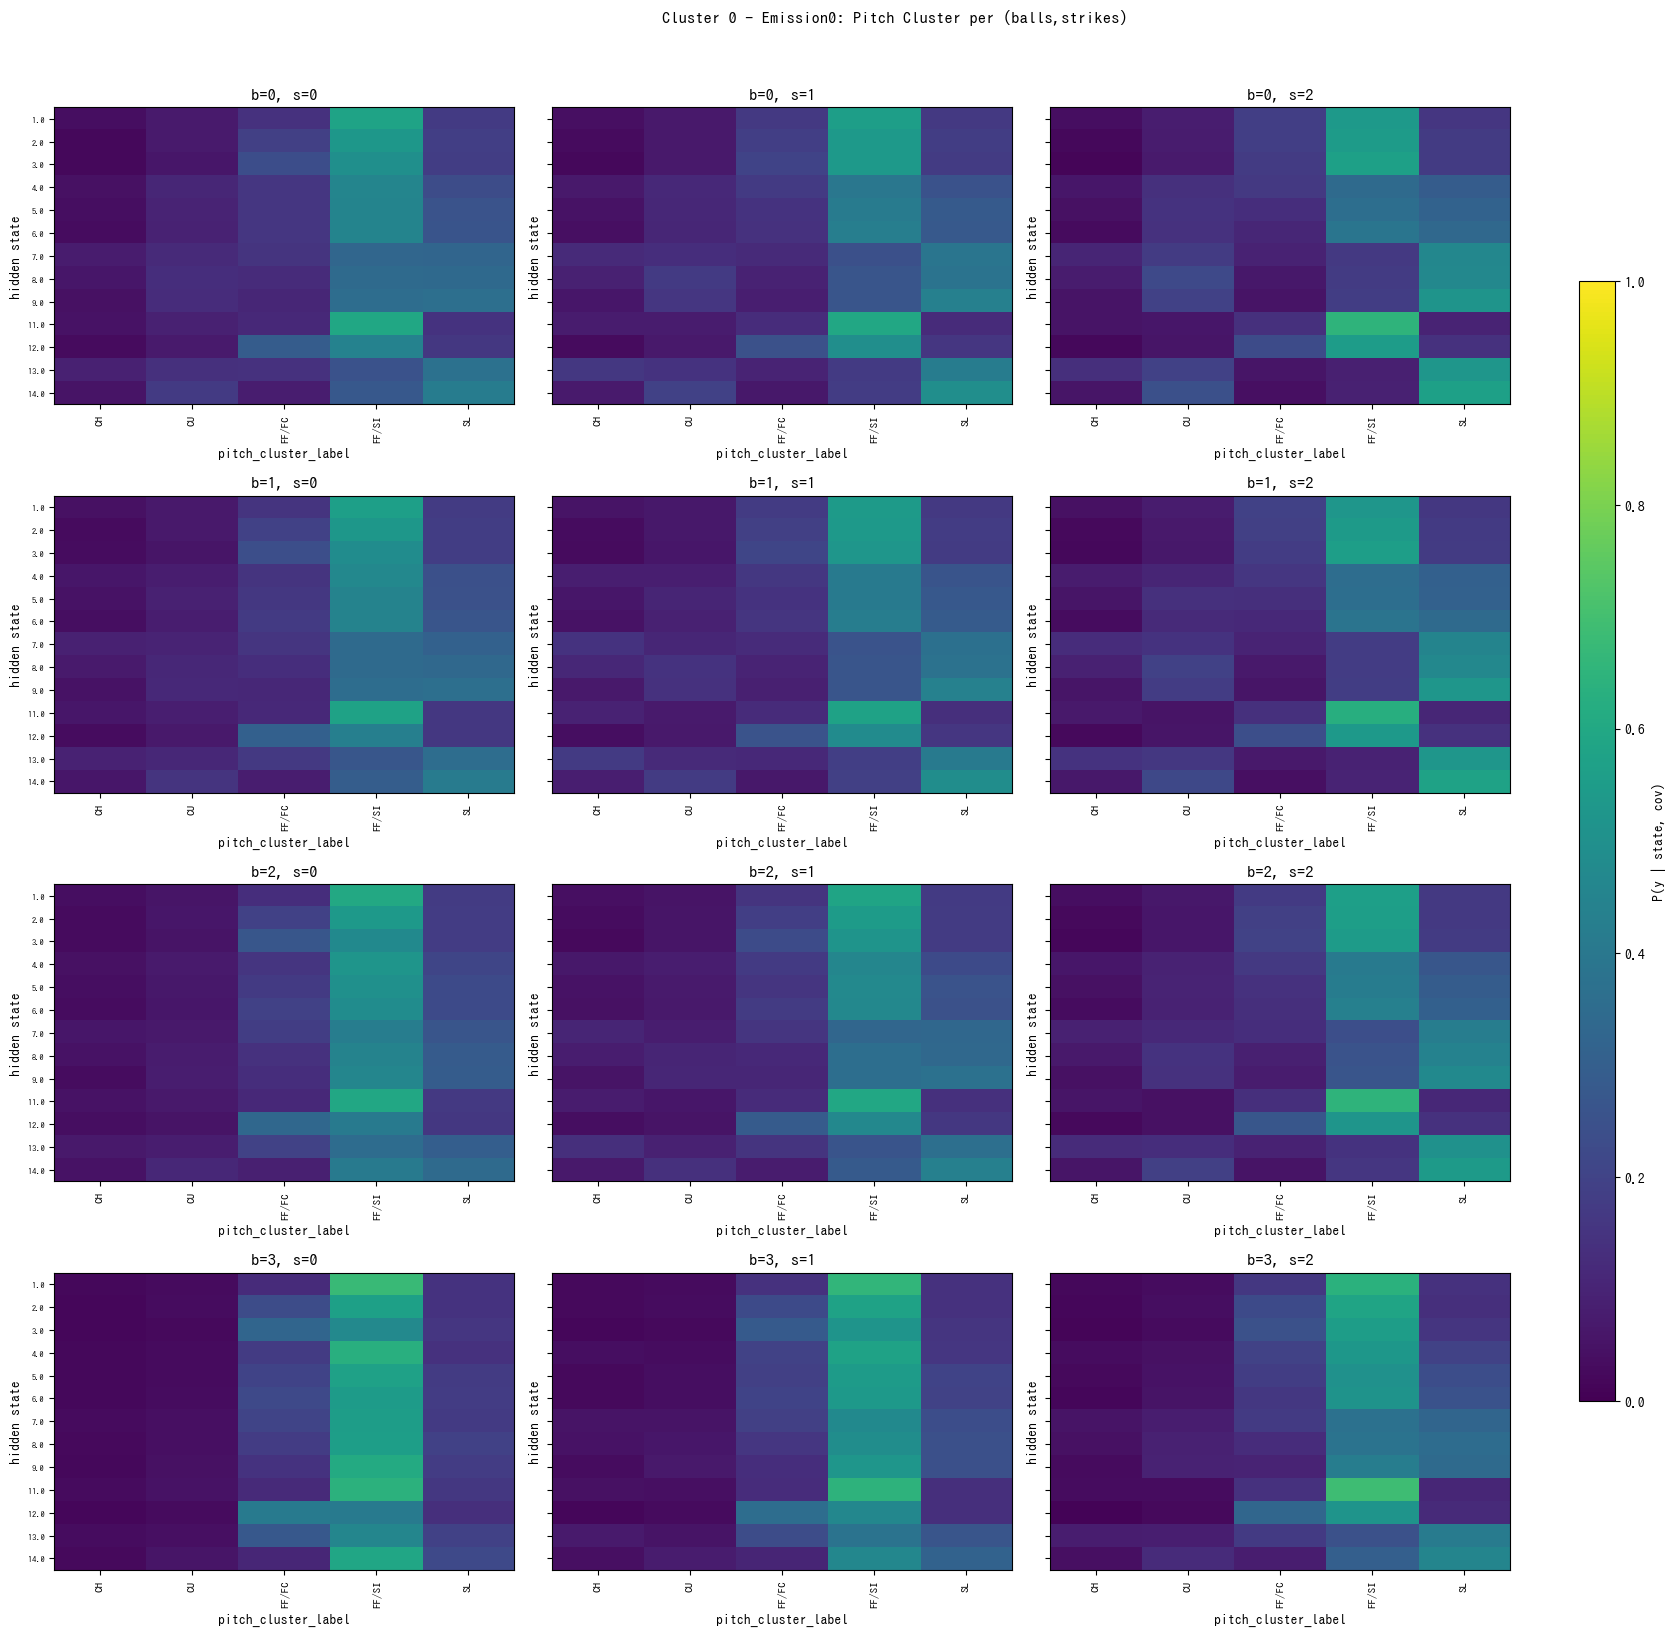

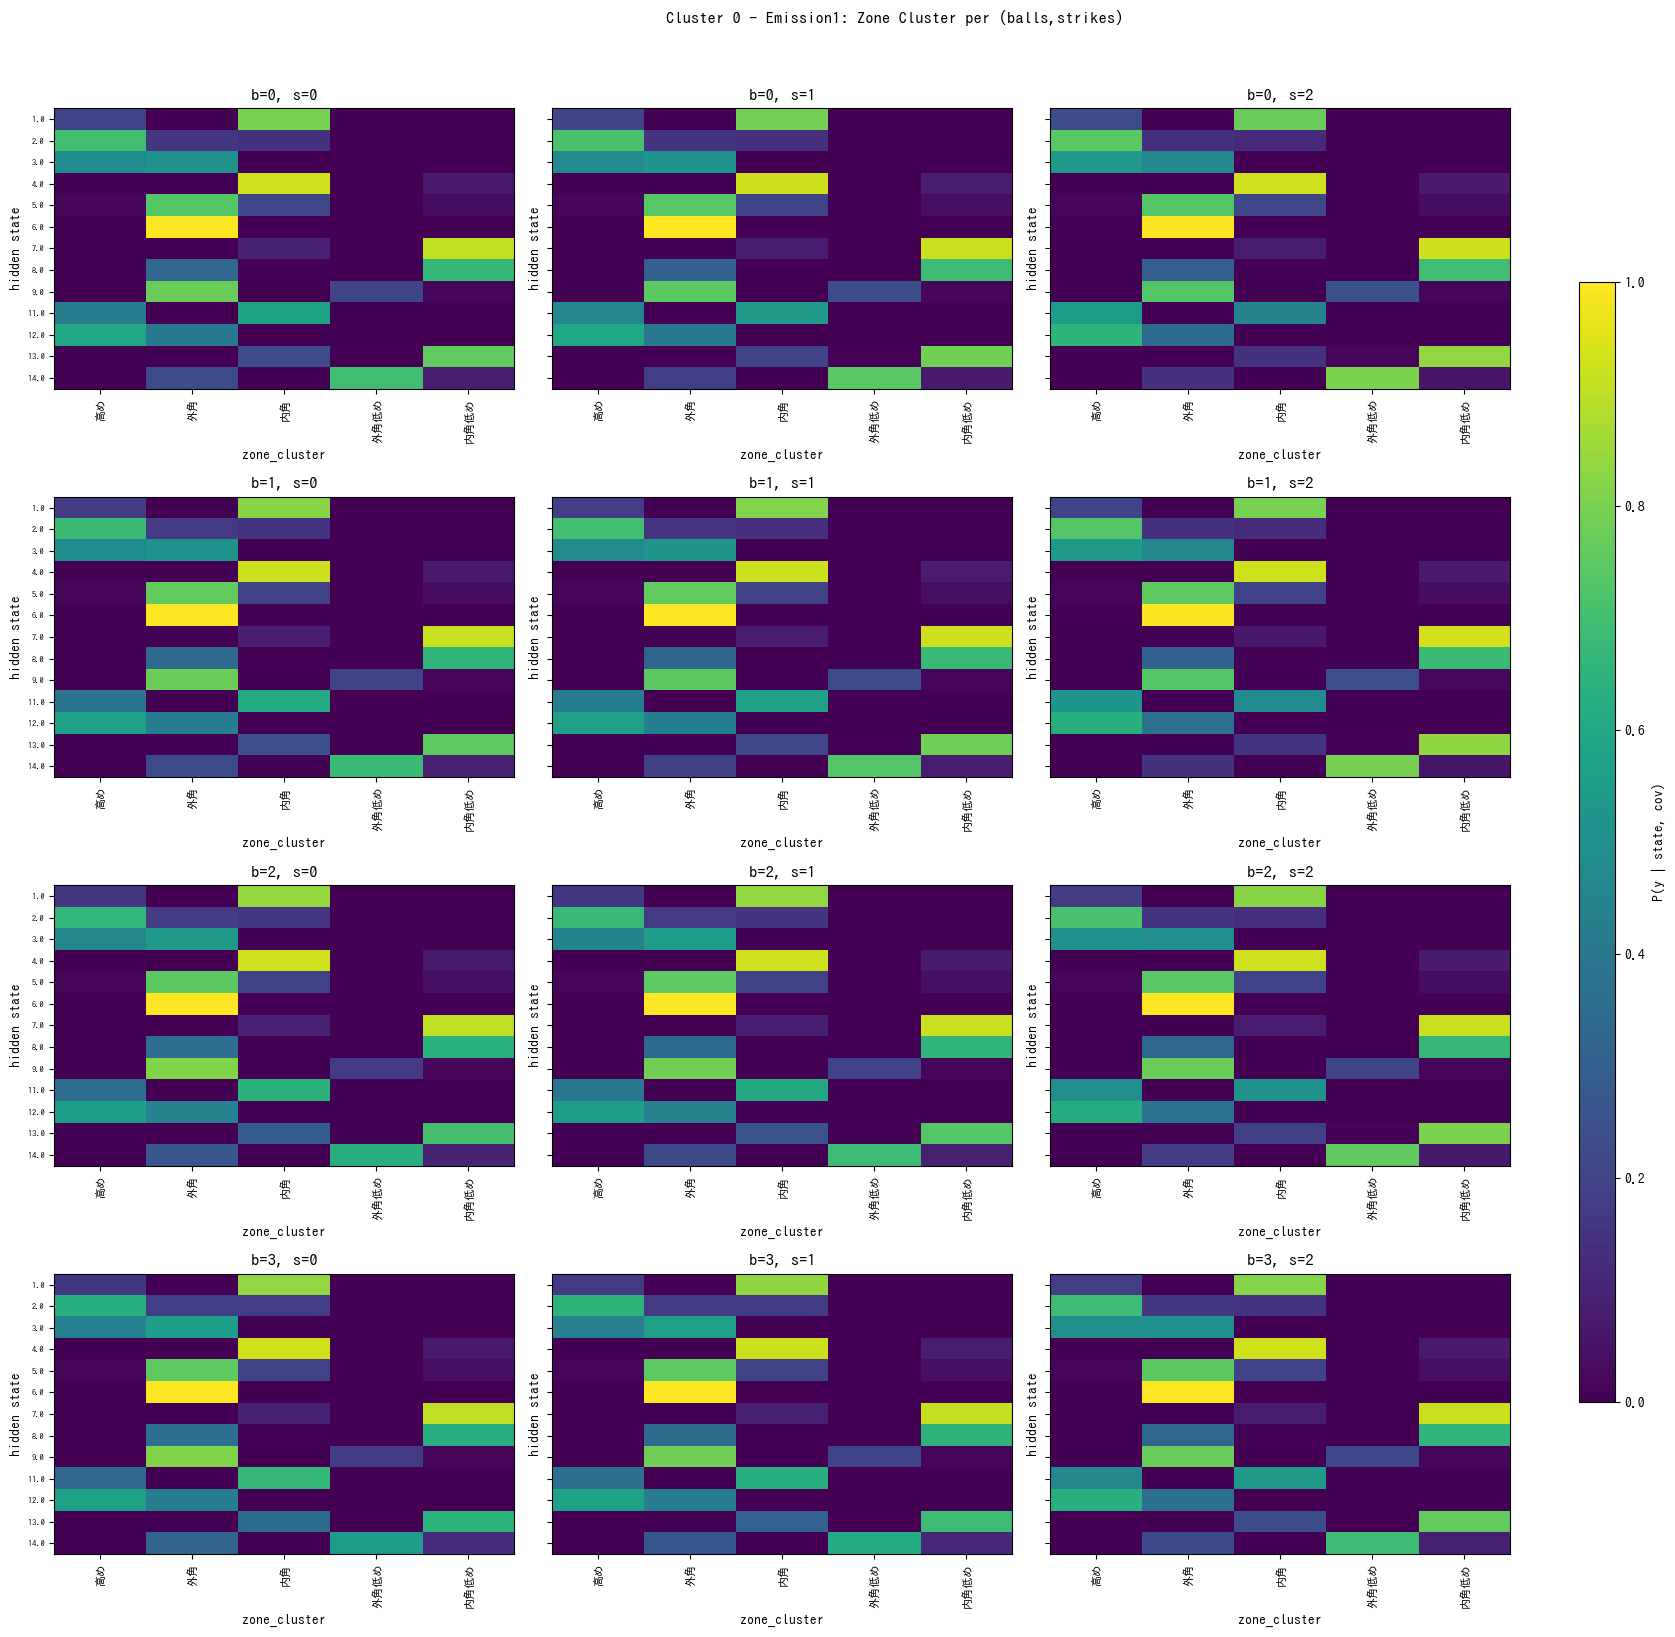

In [55]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from math import ceil

# クラスタリスト（任意で調整）
cluster_list = [0]

# balls-strikes 全パターン
covs = [(b, s) for b in range(4) for s in range(3)]
n_cov = len(covs)
n_cols = 3
n_rows = ceil(n_cov / n_cols)

for cluster in cluster_list:
    model_dir = f"iohmm_cluster_{cluster}_Laplace"
    model_fp = os.path.join(model_dir, "model.pkl")
    enc_fp   = os.path.join(model_dir, "encoders.pkl")

    if not os.path.isfile(model_fp) or not os.path.isfile(enc_fp):
        print(f"[Cluster {cluster}] モデルまたはエンコーダが見つかりません。スキップします。")
        continue

    with open(model_fp, "rb") as mf:
        shmm = pickle.load(mf)
    with open(enc_fp, "rb") as ef:
        encs = pickle.load(ef)

    le_z   = encs["le_zone"]
    le_pcl = encs["le_pitch_cluster_label"]
    le_zcl = encs["le_zone_cluster"]
    ohe    = encs["ohe_input"]

    state_labels = le_z.inverse_transform(np.arange(shmm.num_states))
    pcl_labels   = le_pcl.inverse_transform(np.arange(len(le_pcl.classes_)))
    zcl_labels   = le_zcl.inverse_transform(np.arange(len(le_zcl.classes_)))

    # --- Emission0: pitch_cluster_label ---
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    # 日本語フォントのパス（例: IPAexGothic）
    font_path = "/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf"
    jp_font = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = jp_font.get_name()

    # マイナス記号が文字化けしないように設定
    plt.rcParams['axes.unicode_minus'] = False

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"Cluster {cluster} - Emission0: Pitch Cluster per (balls,strikes)", y=1.02)

    for i, (b, s) in enumerate(covs):
        ax = axes[i]
        x_input = ohe.transform([[b, s]])
        emis0 = np.vstack([
            np.exp(shmm.model_emissions[state][0].predict_log_proba(x_input)[0])
            for state in range(shmm.num_states)
        ])
        im = ax.imshow(emis0, vmin=0, vmax=1, aspect='auto', cmap=cm.viridis)
        ax.set_title(f"b={b}, s={s}")
        ax.set_xticks(range(len(pcl_labels)))
        ax.set_xticklabels(pcl_labels, rotation=90, fontsize=8)
        ax.set_yticks(range(len(state_labels)))
        ax.set_yticklabels(state_labels, fontsize=6)
        ax.set_xlabel("pitch_cluster_label")
        ax.set_ylabel("hidden state")

    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(y | state, cov)")
    plt.tight_layout(rect=[0,0,0.85,1.0])
    plt.show()

    # --- Emission1: zone_cluster ---
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"Cluster {cluster} - Emission1: Zone Cluster per (balls,strikes)", y=1.02)

    zone_map = {0: "高め", 1: "外角", 2: "内角", 3: "外角低め", 4: "内角低め"}
    zcl_names = [zone_map.get(int(lbl), f"Zone{lbl}") for lbl in zcl_labels]

    for i, (b, s) in enumerate(covs):
        ax = axes[i]
        x_input = ohe.transform([[b, s]])
        emis1 = np.vstack([
            np.exp(shmm.model_emissions[state][1].predict_log_proba(x_input)[0])
            for state in range(shmm.num_states)
        ])
        im = ax.imshow(emis1, vmin=0, vmax=1, aspect='auto', cmap=cm.viridis)
        ax.set_title(f"b={b}, s={s}")
        ax.set_xticks(range(len(zcl_names)))
        ax.set_xticklabels(zcl_names, rotation=90, fontsize=8)
        ax.set_yticks(range(len(state_labels)))
        ax.set_yticklabels(state_labels, fontsize=6)
        ax.set_xlabel("zone_cluster")
        ax.set_ylabel("hidden state")

    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(y | state, cov)")
    plt.tight_layout(rect=[0,0,0.85,1.0])
    plt.show()


In [56]:
# evaluate_iohmm_with_confusion_cluster.py
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

# 評価対象のクラスタリスト（必要に応じて調整）
cluster_list = [0]

for cluster in cluster_list:
    dir_name = f"iohmm_cluster_{cluster}_Laplace"
    model_file = os.path.join(dir_name, 'model.pkl')
    test_file  = os.path.join(dir_name, 'test_data.csv')
    enc_file   = os.path.join(dir_name, 'encoders.pkl')

    if not all(os.path.exists(p) for p in [model_file, test_file, enc_file]):
        print(f"[Cluster {cluster}] ファイルが揃っていません。スキップします。")
        continue

    with open(model_file, 'rb') as mf:
        shmm = pickle.load(mf)
    df_test = pd.read_csv(test_file)
    with open(enc_file, 'rb') as ef:
        encs = pickle.load(ef)

    le_z   = encs['le_zone']
    le_pcl = encs['le_pitch_cluster_label']
    le_zcl = encs['le_zone_cluster']
    ohe    = encs['ohe_input']

    # game_pk ごとに系列を作成
    test_dfs = []
    for _, seq_df in df_test.groupby('game_pk'):
        seq = seq_df.reset_index(drop=True)
        test_dfs.append([seq, {}])

    shmm.set_data(test_dfs)
    shmm.E_step()
    posterior_paths = [np.argmax(logg, axis=1) for logg in shmm.log_gammas]

    hidden_true, hidden_pred = [], []
    true_p, pred_p = [], []
    true_z, pred_z = [], []

    for (df, _), path in zip(test_dfs, posterior_paths):
        hidden_true.extend(df['zone'].astype(int).values)
        hidden_pred.extend(path)

        X = ohe.transform(df[['balls','strikes']])
        true_p.append(df['pitch_cluster_label'].values)
        true_z.append(df['zone_cluster'].values)

        pred_p_seq, pred_z_seq = [], []
        for t, s in enumerate(path):
            logp0 = shmm.model_emissions[s][0].predict_log_proba(X[t].reshape(1,-1))
            pred_p_seq.append(int(np.argmax(np.exp(logp0))))

            logp1 = shmm.model_emissions[s][1].predict_log_proba(X[t].reshape(1,-1))
            pred_z_seq.append(int(np.argmax(np.exp(logp1))))

        pred_p.append(np.array(pred_p_seq))
        pred_z.append(np.array(pred_z_seq))

    hidden_true = np.array(hidden_true)
    hidden_pred = np.array(hidden_pred)
    y_true_p = np.hstack(true_p)
    y_pred_p = np.hstack(pred_p)
    y_true_z = np.hstack(true_z)
    y_pred_z = np.hstack(pred_z)

    acc_hidden = accuracy_score(hidden_true, hidden_pred)
    acc_p      = accuracy_score(y_true_p, y_pred_p)
    acc_z      = accuracy_score(y_true_z, y_pred_z)

    print(f"[Cluster {cluster}] Hidden accuracy: {acc_hidden:.4f}")
    print(f"[Cluster {cluster}] Pitch-cluster accuracy: {acc_p:.4f}")
    print(f"[Cluster {cluster}] Zone-cluster accuracy:  {acc_z:.4f}")

    # 混同行列
    cm_hidden = confusion_matrix(hidden_true, hidden_pred)
    cm_pcl    = confusion_matrix(y_true_p, y_pred_p)
    cm_zcl    = confusion_matrix(y_true_z, y_pred_z)

    df_cm_hidden = pd.DataFrame(cm_hidden, index=le_z.classes_, columns=le_z.classes_)
    df_cm_pcl    = pd.DataFrame(cm_pcl,    index=le_pcl.classes_, columns=le_pcl.classes_)
    df_cm_zcl    = pd.DataFrame(cm_zcl,    index=le_zcl.classes_, columns=le_zcl.classes_)

    # 保存
    df_cm_hidden.to_csv(os.path.join(dir_name, 'cm_hidden_hot.csv'))
    df_cm_pcl.to_csv(os.path.join(dir_name, 'cm_pitch_cluster_hot.csv'))
    df_cm_zcl.to_csv(os.path.join(dir_name, 'cm_zone_cluster_hot.csv'))
    with open(os.path.join(dir_name, 'evaluation_accuracy_hot.txt'), 'w') as outf:
        outf.write(f"hidden_state_accuracy: {acc_hidden:.4f}\n")
        outf.write(f"pitch_cluster_accuracy: {acc_p:.4f}\n")
        outf.write(f"zone_cluster_accuracy:  {acc_z:.4f}\n")


[Cluster 0] Hidden accuracy: 0.4208
[Cluster 0] Pitch-cluster accuracy: 0.5374
[Cluster 0] Zone-cluster accuracy:  0.8025


In [6]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

def viterbi_decode_supervised(model, df, input_features, obs_features):
    X      = df[input_features].values
    #y_emit = df[obs_feature].astype(int).values
    y_emit = {f: df[f].astype(int).values for f in obs_features}
    T      = len(df)
    N      = model.num_states

    # 初期分布
    x0   = X[0].reshape(1, -1)
    init = model.model_initial
    if isinstance(init, list):
        init = init[0]
    log_pi = init.predict_log_proba(x0)[0]

    # 遷移＆エミッションモデル
    trans_models = model.model_transition
    emis_models  = [em_list[0] for em_list in model.model_emissions]

    # Viterbi テーブル＆ポインタ
    log_delta = np.full((T, N), -np.inf)
    psi       = np.zeros((T, N), dtype=int)

    # t=0
    for s in range(N):
        # 複数観測の log 確率を合算
        log_e0 = 0.0
        for i, em in enumerate(model.model_emissions[s]):
            obs = y_emit[obs_features[i]][0]
            log_e0 += em.predict_log_proba(x0)[0][obs]
        log_delta[0, s] = log_pi[s] + log_e0

    # t>=1
    for t in range(1, T):
        x_t = X[t].reshape(1, -1)
        for s in range(N):
            best_score, best_sp = -np.inf, 0
            for sp in range(N):
                tm = trans_models[sp] if isinstance(trans_models, list) else trans_models
                log_a = tm.predict_log_proba(x_t)[0][s]
                score = log_delta[t-1, sp] + log_a
                if score > best_score:
                    best_score, best_sp = score, sp
                # pitch＋zone の両方の emission を合算
            log_e = 0.0
            for i, em in enumerate(model.model_emissions[s]):
                obs = y_emit[obs_features[i]][t]
                log_e += em.predict_log_proba(x_t)[0][obs]
            log_delta[t, s] = best_score + log_e
            psi[t, s]       = best_sp

    # 逆追跡
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(log_delta[-1])
    for t in range(T-2, -1, -1):
        path[t] = psi[t+1, path[t+1]]

    return path


def evaluate_supervised_iohmm(cluster_list, obs_features):
    """
    cluster_list   : list of int, e.g. [0,1,...]
    obs_features   : list of str, ['pitch_cluster_label','zone_cluster']
    """
    for cluster in cluster_list:
        dir_name = f"iohmm_cluster_{cluster}_Laplace"

        # モデル・テストデータ・エンコーダー読み込み
        with open(os.path.join(dir_name, 'model.pkl'), 'rb') as f:
            shmm = pickle.load(f)
        df_test = pd.read_csv(os.path.join(dir_name, 'test_data.csv'))
        encs    = pickle.load(open(os.path.join(dir_name, 'encoders.pkl'), 'rb'))
        feats   = encs['input_features']   # すでにワンホット化されたカラム名リスト

        # 真値／予測リスト
        hidden_true, hidden_pred = [], []
        true_p, true_z = [], []
        pred_p, pred_z = [], []

        # pitcher×game_pk ごとに Viterbi
        for _, group in df_test.groupby(['pitcher','game_pk']):
            seq  = group.reset_index(drop=True)
            path = viterbi_decode_supervised(shmm, seq, feats, obs_features)

            # 隠れ状態の評価
            hidden_true.extend(seq['zone'].astype(int).values)
            hidden_pred.extend(path)

            # X を直接取り出し
            X = seq[feats].values
            pp_seq, pz_seq = [], []
            for t, s in enumerate(path):
                # pitch_cluster
                logp0 = shmm.model_emissions[s][0].predict_log_proba(X[t].reshape(1, -1))[0]
                pp_seq.append(int(np.argmax(logp0)))
                # zone_cluster
                logp1 = shmm.model_emissions[s][1].predict_log_proba(X[t].reshape(1, -1))[0]
                pz_seq.append(int(np.argmax(logp1)))

            true_p.append(seq[obs_features[0]].astype(int).values)
            true_z.append(seq[obs_features[1]].astype(int).values)
            pred_p.append(np.array(pp_seq))
            pred_z.append(np.array(pz_seq))

        # NumPy化＆評価
        y_true_h = np.array(hidden_true); y_pred_h = np.array(hidden_pred)
        y_true_p = np.hstack(true_p);      y_pred_p = np.hstack(pred_p)
        y_true_z = np.hstack(true_z);      y_pred_z = np.hstack(pred_z)

        acc_h = accuracy_score(y_true_h, y_pred_h)
        acc_p = accuracy_score(y_true_p, y_pred_p)
        acc_z = accuracy_score(y_true_z, y_pred_z)

        print(f"[Cluster {cluster}] Hidden accuracy (Viterbi):  {acc_h:.4f}")
        print(f"[Cluster {cluster}] Pitch-cluster accuracy:    {acc_p:.4f}")
        print(f"[Cluster {cluster}] Zone-cluster accuracy:      {acc_z:.4f}")

        # 混同行列保存
        pd.DataFrame(confusion_matrix(y_true_h, y_pred_h)) \
          .to_csv(os.path.join(dir_name, 'cm_hidden_viterbi.csv'), index=True)
        pd.DataFrame(confusion_matrix(y_true_p, y_pred_p)) \
          .to_csv(os.path.join(dir_name, 'cm_pitch_cluster_viterbi.csv'), index=True)
        pd.DataFrame(confusion_matrix(y_true_z, y_pred_z)) \
          .to_csv(os.path.join(dir_name, 'cm_zone_cluster_viterbi.csv'), index=True)

        # テキストにもまとめ
        with open(os.path.join(dir_name, 'evaluation_accuracy_viterbi.txt'), 'w') as f:
            f.write(f"hidden_state_accuracy:   {acc_h:.4f}\n")
            f.write(f"pitch_cluster_accuracy:  {acc_p:.4f}\n")
            f.write(f"zone_cluster_accuracy:   {acc_z:.4f}\n")


if __name__ == "__main__":
    evaluate_supervised_iohmm([0], ['pitch_cluster_label','zone_cluster'])


[Cluster 0] Hidden accuracy (Viterbi):  0.4171
[Cluster 0] Pitch-cluster accuracy:    0.5424
[Cluster 0] Zone-cluster accuracy:      0.7890


In [13]:
print(type(shmm.model_transition))


<class 'list'>


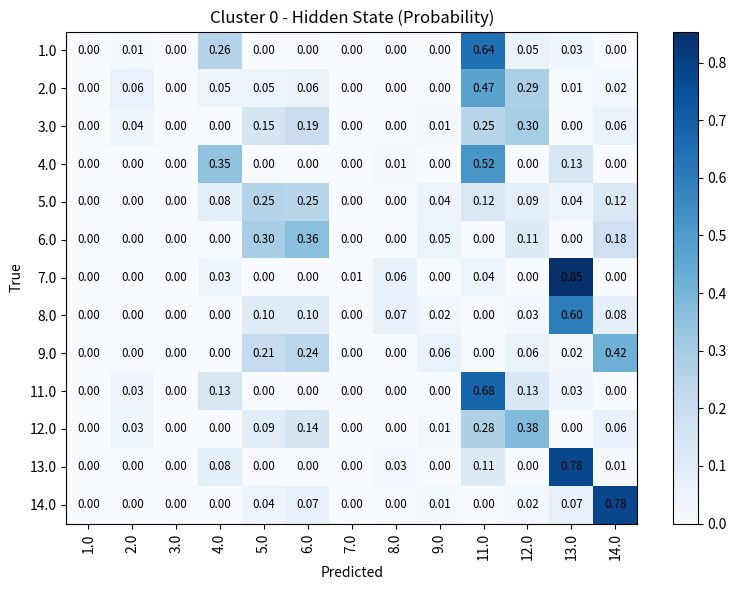

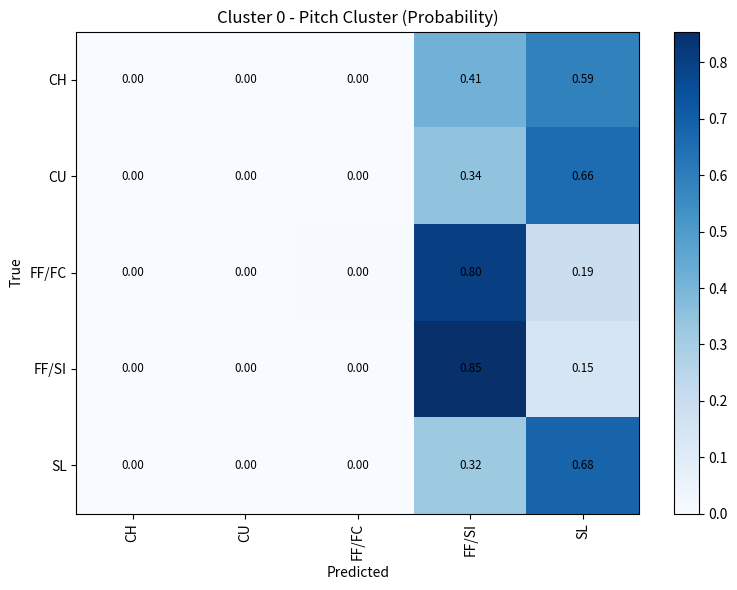

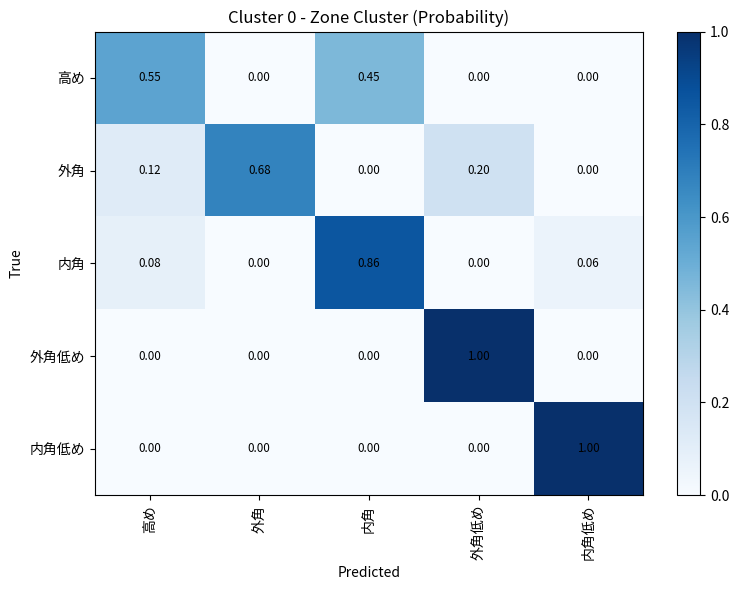

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# Zone Cluster の日本語名マップ
zone_names = {
    0: "高め",
    1: "外角",
    2: "内角",
    3: "外角低め",
    4: "内角低め"
}

# 評価対象のクラスタリスト
cluster_list = [0]

# 混同行列ファイルのマッピング
matrix_files = {
    "Hidden State":    "cm_hidden_hot.csv",
    "Pitch Cluster":   "cm_pitch_cluster_hot.csv",
    "Zone Cluster":    "cm_zone_cluster_hot.csv"
}

# 日本語フォントの指定（適宜環境に応じて変更）
jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')
rcParams['font.family'] = jp_font.get_name()
rcParams['axes.unicode_minus'] = False

for cluster in cluster_list:
    dir_name = f"iohmm_cluster_{cluster}_Laplace"
    for title, filename in matrix_files.items():
        path = os.path.join(dir_name, filename)
        if not os.path.exists(path):
            print(f"[Cluster {cluster}] {filename} が見つかりません。スキップします。")
            continue

        df_cm = pd.read_csv(path, index_col=0)
        df_prop = df_cm.div(df_cm.sum(axis=1), axis=0).fillna(0)

        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(df_prop.values, aspect='auto', cmap='Blues')
        plt.colorbar(im, ax=ax)

        # 軸ラベル設定
        if title == "Zone Cluster":
            x_labels = [zone_names.get(int(c), str(c)) for c in df_prop.columns]
            y_labels = [zone_names.get(int(c), str(c)) for c in df_prop.index]
        else:
            x_labels = [str(c) for c in df_prop.columns]
            y_labels = [str(c) for c in df_prop.index]

        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=90)
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels)

        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"Cluster {cluster} - {title} (Probability)")

        # 数値注記
        for i in range(df_prop.shape[0]):
            for j in range(df_prop.shape[1]):
                ax.text(j, i, f"{df_prop.iat[i,j]:.2f}",
                        ha="center", va="center", fontsize='small', color='black')

        plt.tight_layout()
        plt.show()


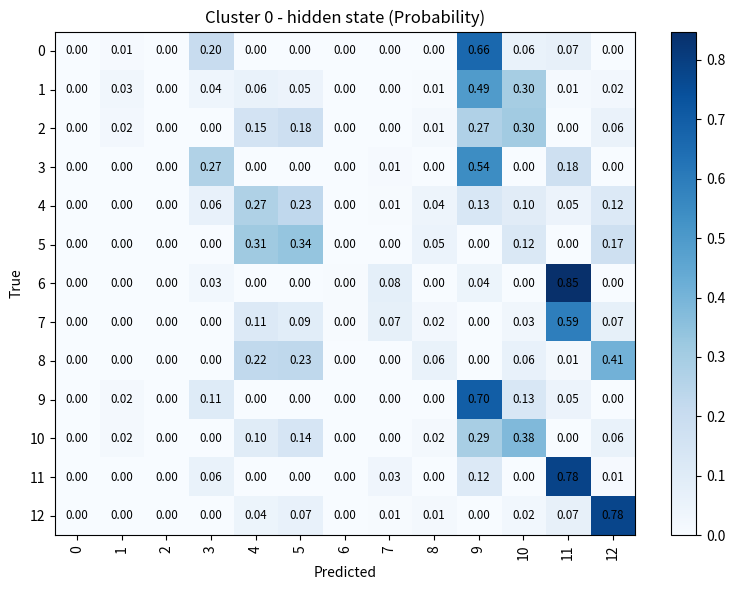

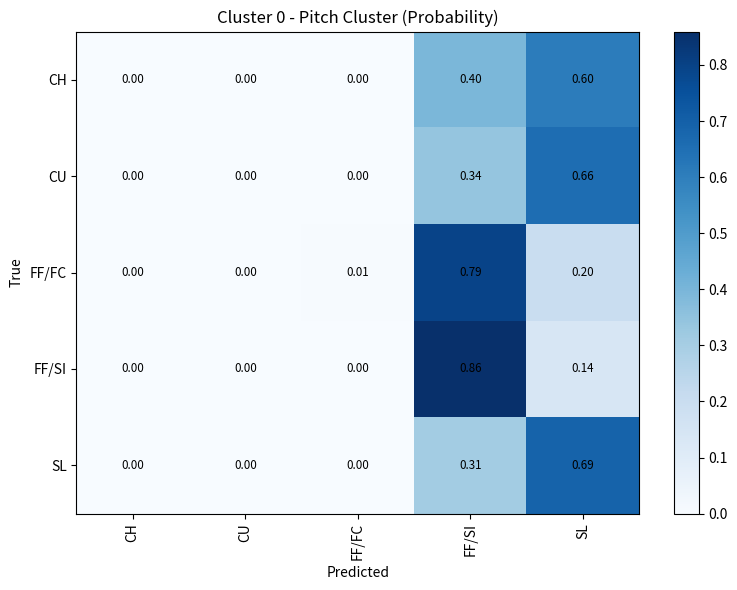

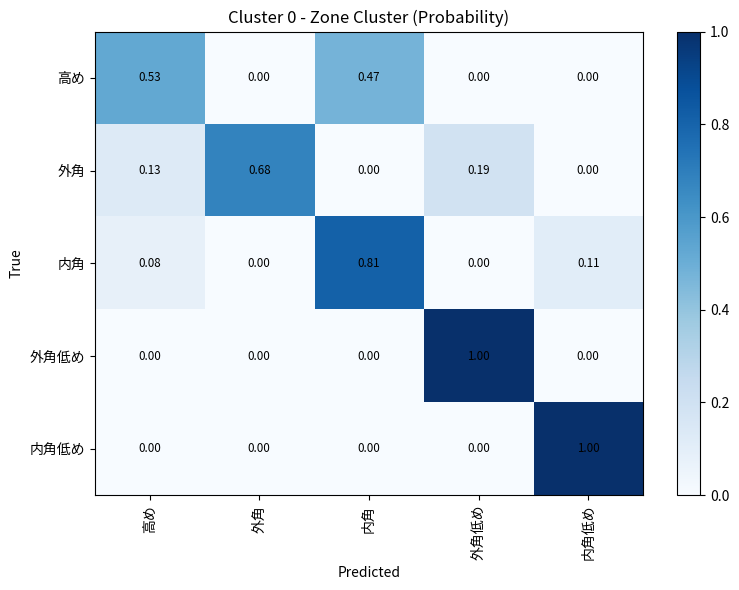

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# Zone Cluster の日本語名マップ
zone_names = {
    0: "高め",
    1: "外角",
    2: "内角",
    3: "外角低め",
    4: "内角低め"
}

pitch_names = {
    0:"CH",
    1:"CU",
    2:"FF/FC",
    3:"FF/SI",
    4:"SL"
}

# 評価対象のクラスタリスト
cluster_list = [0]

# 混同行列ファイルのマッピング
matrix_files = {
    "hidden state":   "cm_hidden_viterbi.csv",
    "Pitch Cluster":   "cm_pitch_cluster_viterbi.csv",
    "Zone Cluster":    "cm_zone_cluster_viterbi.csv"
}

# 日本語フォントの指定（適宜環境に応じて変更）
jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')
rcParams['font.family'] = jp_font.get_name()
rcParams['axes.unicode_minus'] = False

for cluster in cluster_list:
    dir_name = f"iohmm_cluster_{cluster}_Laplace"
    for title, filename in matrix_files.items():
        path = os.path.join(dir_name, filename)
        if not os.path.exists(path):
            print(f"[Cluster {cluster}] {filename} が見つかりません。スキップします。")
            continue

        df_cm = pd.read_csv(path, index_col=0)
        df_prop = df_cm.div(df_cm.sum(axis=1), axis=0).fillna(0)

        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(df_prop.values, aspect='auto', cmap='Blues')
        plt.colorbar(im, ax=ax)

        # 軸ラベル設定
        if title == "Zone Cluster":
            x_labels = [zone_names.get(int(c), str(c)) for c in df_prop.columns]
            y_labels = [zone_names.get(int(c), str(c)) for c in df_prop.index]
        elif title == "Pitch Cluster":
            x_labels = [pitch_names.get(int(c), str(c)) for c in df_prop.columns]
            y_labels = [pitch_names.get(int(c), str(c)) for c in df_prop.index]
        else:
            x_labels = [str(c) for c in df_prop.columns]
            y_labels = [str(c) for c in df_prop.index]

        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=90)
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels)

        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"Cluster {cluster} - {title} (Probability)")

        # 数値注記
        for i in range(df_prop.shape[0]):
            for j in range(df_prop.shape[1]):
                ax.text(j, i, f"{df_prop.iat[i,j]:.2f}",
                        ha="center", va="center", fontsize='small', color='black')

        plt.tight_layout()
        plt.show()
